<a href="https://colab.research.google.com/github/andrewpulsifr/MiddleOfTheCurve/blob/main/COMP432_PROJECT_SUBMISSION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mount google drive as source for data loading.**


### Mount and General use imports.

In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [181]:
from google.colab import drive
drive.mount('/content/drive')  # follow the prompt

DATA_DIR   = "/content/drive/MyDrive/DATA_DIR"
TRAIN_PATH = f"{DATA_DIR}/train.csv"
TEST_PATH  = f"{DATA_DIR}/test.csv"
SAMPLE_SUB = f"{DATA_DIR}/sample_submission.csv"


!ls -lh "$DATA_DIR"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
total 400M
drwx------ 2 root root 4.0K Nov 29 04:41 exp_logs
drwx------ 4 root root 4.0K Nov 24 21:07 runs
-rw------- 1 root root 376K Nov  3 21:17 sample_submission.csv
drwx------ 2 root root 4.0K Nov 29 03:54 submissions
-rw------- 1 root root 120M Nov  3 21:17 test.csv
-rw------- 1 root root 280M Nov  3 21:17 train.csv


Read csv from content folder.

In [182]:
# Attempt loading from cs
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
print("Shapes:", train.shape, test.shape)  # expecting (115406, 502) and (49460, 501)

Shapes: (115406, 502) (49460, 501)


## Data Inspection

### Check Integrity of the data scheme


Confirm data scheme matches spec.

**Spec**: *id , feature_0..feature_499, and label (0–49) in train; id + 500 features in test*

In [183]:
print(train.shape, test.shape)
train.head()

(115406, 502) (49460, 501)


,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_491,feature_492,feature_493,feature_494,feature_495,feature_496,feature_497,feature_498,feature_499,label
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.063888,43
1,1,0.000000,0.000000,0.000000,0.071982,0.000000,0.000000,0.000000,0.071982,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.071982,0.0,0.000000,16
2,2,0.111111,0.000000,0.111111,0.000000,0.000000,0.111111,0.000000,0.111111,0.000000,...,0.000000,0.111111,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,21
3,3,0.000000,0.087039,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.087039,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,2
4,4,0.000000,0.000000,0.069673,0.000000,0.069673,0.000000,0.069673,0.000000,0.000000,...,0.069673,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1


In [184]:
# Inspect dataset
print("Shape:", train.shape)
print("Columns:", train.columns)
print(train.describe())   # summary stats

Shape: (115406, 502)
Columns: Index(['id', 'feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8',
       ...
       'feature_491', 'feature_492', 'feature_493', 'feature_494',
       'feature_495', 'feature_496', 'feature_497', 'feature_498',
       'feature_499', 'label'],
      dtype='object', length=502)
                 id      feature_0      feature_1      feature_2  \
count  115406.00000  115406.000000  115406.000000  115406.000000   
mean    57702.50000       0.019694       0.015188       0.018202   
std     33314.98692       0.048032       0.046823       0.045241   
min         0.00000       0.000000       0.000000       0.000000   
25%     28851.25000       0.000000       0.000000       0.000000   
50%     57702.50000       0.000000       0.000000       0.000000   
75%     86553.75000       0.000000       0.000000       0.000000   
max    115405.00000       0.635001       0.548821       0.500000   

         

Ensure that the column names and length matches expectation and that there are no missing values.

In [185]:
# Columns & types
print("Columns:", len(train.columns))
print("Example cols:", train.columns[:10].tolist())

# NA checks
na_train = train.isna().sum().sum()
na_test  = test.isna().sum().sum()
print(f"Missing (train): {na_train:,} | Missing (test): {na_test:,}")

Columns: 502
Example cols: ['id', 'feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8']
Missing (train): 0 | Missing (test): 0


Confirm there are no duplicate ids and that labels cover the required range and are already integer endcoded.

In [186]:
# ID uniqueness
assert train['id'].is_unique, "train id not unique"
assert test['id'].is_unique, "test id not unique"

# Label domain
labels = train['label'].unique()
print("Num classes:", len(labels), "| label min/max:", labels.min(), labels.max())

Num classes: 50 | label min/max: 0 49


Calculate how many times each unique label appears in the training data and display it in a data frame to see the distrubtion. Then using a bar chart visualize distribution.



In [187]:
label_counts = train['label'].value_counts().sort_index()
display(label_counts.to_frame("count").T)

label,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,2309,2306,2307,2309,2309,2309,2310,2307,2304,2309,...,2310,2310,2308,2308,2306,2310,2307,2305,2310,2309


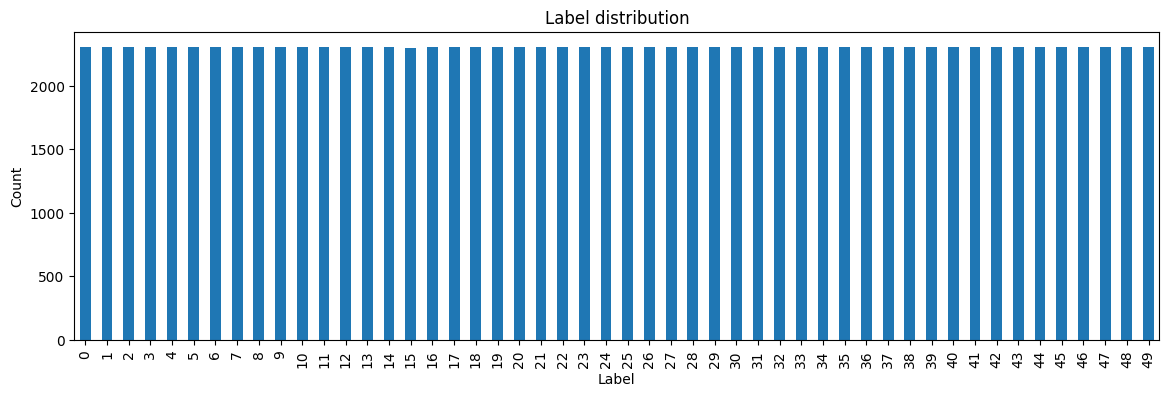

In [188]:
# Plot
ax = label_counts.plot(kind="bar", figsize=(14,4)) # plot bar graph with set size
ax.set_title("Label distribution")
ax.set_xlabel("Label")
ax.set_ylabel("Count")
plt.show() # display generated plot

### Gather information and create a basedline.

Determine the number of distinct classes and determine the accuracy of correct label assuming uniform distribution.

Then determine the accuracy if you were to predict the most frequent class

**Goal**: Establish a basline accuracy of predicting labels by pure chance and by majority rules.

**Output**: Confirms that labels are well-distributed and sets a baseline to far exceed.

In [189]:
n_classes = label_counts.shape[0] # returns a tuple representing dimensions of the series (number of rows)
chance = 1.0 / n_classes # chance if guessing uniformly at random
majority = label_counts.max() / len(train) # divide most common by length of set to see accuracy with most common
print(f"Chance baseline (uniform): {chance:.3%}")
print(f"Majority-class baseline:   {majority:.3%}")

Chance baseline (uniform): 2.000%
Majority-class baseline:   2.002%


Output to determine the characteristics of features such as.

**Variability**

To determine

1.   Feature selection
2.   Scaling
3. Model choice

In [190]:
feature_cols = [c for c in train.columns if c.startswith("feature_")] # collect all feature columns
X = train[feature_cols].values.astype(np.float64) # create array containing feature data

# Per-feature statistical summary
means = X.mean(axis=0)
stds  = X.std(axis=0)
mins  = X.min(axis=0)
maxs  = X.max(axis=0)
vars_ = X.var(axis=0)

Organizing Calcualted statistics into a data frame in the order of highest to lowest variance.

**Syntax**

1.   `pd.DataFrame({...})`: Creates a new pandas DataFrame. The data for the DataFrame is provided as a dictionary where keys are the desired column names and values are from the array.
2.   `.sort_values("var", ascending=False)`: Sorts the DataFrame in descending order based on the "var" (variance) column.


In [191]:
summary = pd.DataFrame({
    "feature": feature_cols,
    "mean": means,
    "std": stds,
    "min": mins,
    "max": maxs,
    "var": vars_
}).sort_values("var", ascending=False)

summary.head(10)

,feature,mean,std,min,max,var
39,feature_39,0.041883,0.099038,0.0,0.909137,0.009809
425,feature_425,0.050261,0.090853,0.0,0.917663,0.008254
348,feature_348,0.035961,0.085746,0.0,0.872872,0.007352
269,feature_269,0.042330,0.084952,0.0,0.912871,0.007217
137,feature_137,0.014705,0.080460,0.0,0.957704,0.006474
319,feature_319,0.044862,0.079087,0.0,0.733799,0.006255
422,feature_422,0.034313,0.077150,0.0,0.962520,0.005952
153,feature_153,0.037448,0.073173,0.0,0.707107,0.005354
22,feature_22,0.032881,0.071691,0.0,0.782624,0.005140
399,feature_399,0.026652,0.071363,0.0,0.766131,0.005093


**see analysis for output take aways*

Inspect the spread of values of the features with highest varies against random features.

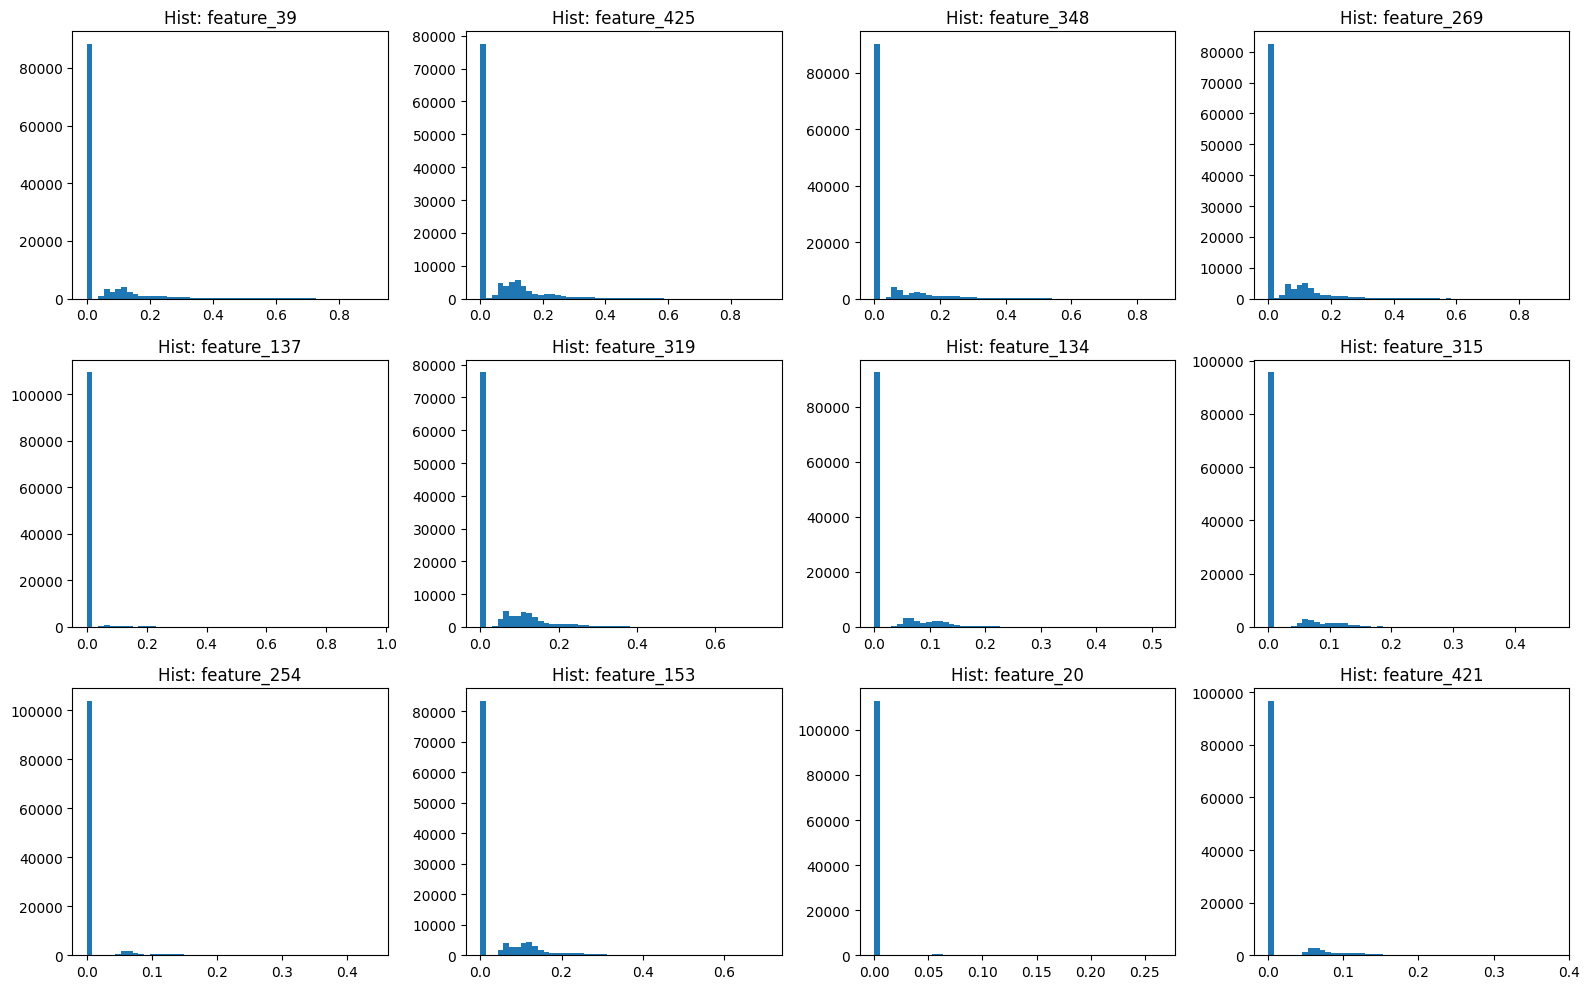

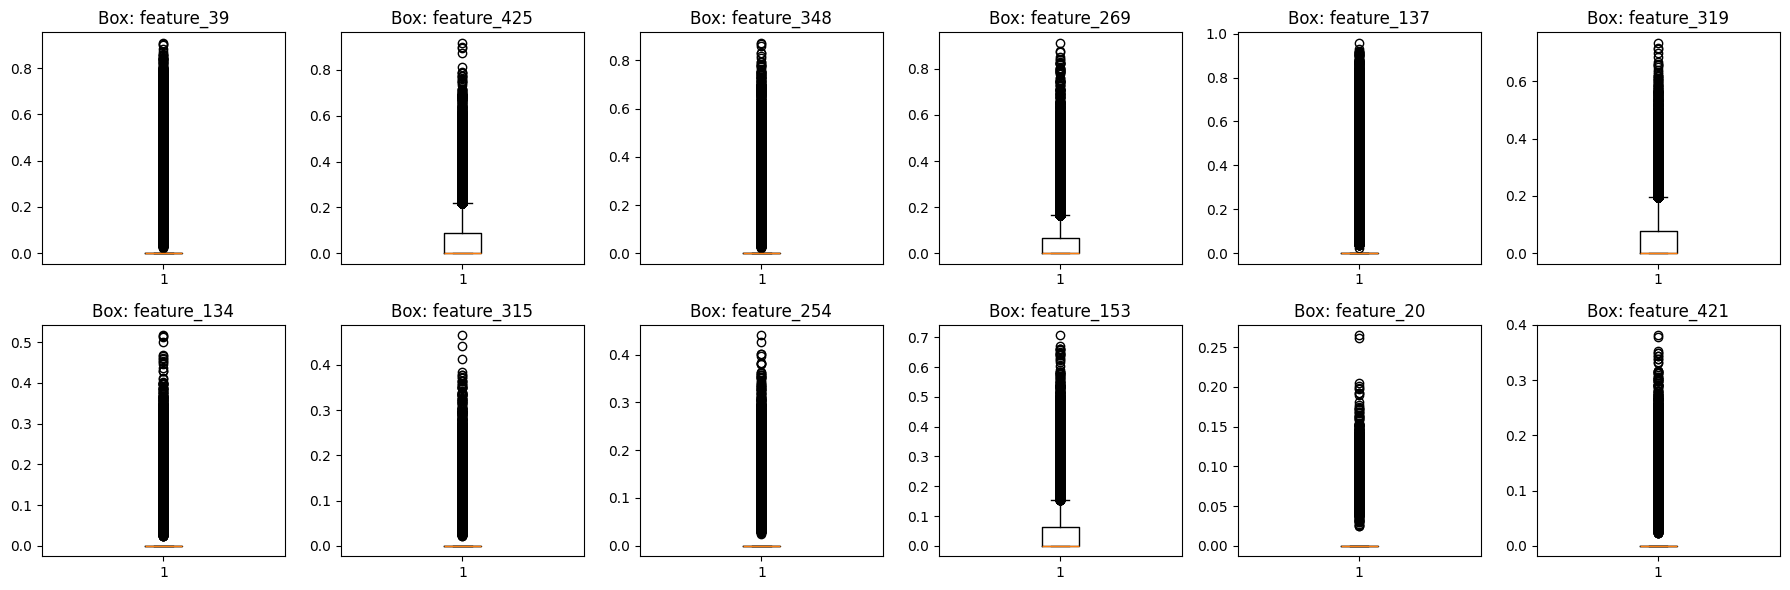

In [192]:
top_k = 6 # predetermine number of top variance features to show
top_var_feats = summary.head(top_k)['feature'].tolist() # list of top var features
rand_feats = list(np.random.default_rng(0).choice(feature_cols, size=6, replace=False)) # randomly select features from the list
inspect_feats = top_var_feats + rand_feats # combine into 12 unique features to test

fig, axes = plt.subplots(3, 4, figsize=(16,10))
axes = axes.ravel()
for i, f in enumerate(inspect_feats[:12]):
    axes[i].hist(train[f].values, bins=50)
    axes[i].set_title(f"Hist: {f}")
plt.tight_layout(); plt.show()

# Boxplots (spot outliers)
fig, axes = plt.subplots(2, 6, figsize=(18,6))
axes = axes.ravel()
for i, f in enumerate(inspect_feats[:12]):
    axes[i].boxplot(train[f].values, vert=True, showfliers=True)
    axes[i].set_title(f"Box: {f}")
plt.tight_layout(); plt.show()

 ***see analysis of data in technical analysis.*

# Logging and tracking of Best Run.

Helpers to keep track of best runs and to analyze the impact of changes.

**Note**: Section was a combination of lab reference and LLM to assistance. Reasoning is that it's not a core part of model logic and better logging structure was helpful


## Best run tracking

### Google Drive directory secup for checkpoint and logs

In [193]:
import os, json, time, math                     # os for files/paths, json to persist runs, time for durations
from datetime import datetime, timezone         # ISO timestamps for log readability
import numpy as np                              # reproducible RNG seeding for NumPy
import torch                                    # reproducible RNG seeding for Torch
from datetime import datetime, UTC

In [194]:
# ----- Best-run tracking: setup ----
# Purpose: keep the best model by val_acc in memory and on disk

# Root dirs using the existing DATA_DIR
RUNS_DIR   = os.path.join(DATA_DIR, "runs")
CKPT_DIR   = os.path.join(RUNS_DIR, "checkpoints")
META_DIR   = os.path.join(RUNS_DIR, "meta")
os.makedirs(CKPT_DIR, exist_ok=True)
os.makedirs(META_DIR, exist_ok=True)

EXP_DIR  = os.path.join(DATA_DIR, "exp_logs")
LOG_JSON = os.path.join(EXP_DIR, "experiments.log")# JSONL: one JSON per line
LOG_TXT  = os.path.join(EXP_DIR, "readable.txt") # human-readable summary
os.makedirs(EXP_DIR, exist_ok=True)

# Global pointer to current best current stored in memory
GLOBAL_BEST = None     # will hold {"name": str, "val_acc": float, "model": nn.Module, "ckpt_path": str, "meta_path": str}
BEST_JSON   = os.path.join(META_DIR, "GLOBAL_BEST.json")  # json storage to persist global best across sessions.

### Best run checkpoint helpers

In [195]:
def _state_dict_cpu(model: torch.nn.Module) -> dict:
    """
    Clone the model's state_dict onto CPU tensors for safety in different devices.
    Might be a good safety net when switching from GPU to CPU on Colab.
    """
    return {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

def _save_checkpoint(name: str, model: torch.nn.Module, extras: dict) -> tuple[str, str]:
    """
    Save a checkpoint (.pt) and a JSON sidecar with metadata.
    Returns: (ckpt_path, meta_path)
    """
    ts = time.strftime("%Y%m%d-%H%M%S")
    base = f"{name}__{ts}"
    ckpt_path = os.path.join(CKPT_DIR, f"{base}.pt")
    meta_path = os.path.join(META_DIR, f"{base}.json")

    payload = {
        "state_dict": _state_dict_cpu(model),
        "extras": extras or {},
    }
    torch.save(payload, ckpt_path)

    with open(meta_path, "w") as f:
        json.dump(payload["extras"], f, indent=2)

    return ckpt_path, meta_path

def _persist_global_best_pointer(best_dict: dict) -> None:
    """
    Write a tiny JSON file that records which run is currently the best.
    """
    safe = {k: v for k, v in best_dict.items() if k != "model"}
    with open(BEST_JSON, "w") as f:
        json.dump(safe, f, indent=2)

def load_global_best_pointer() -> dict | None:
    """
    Reload the best-run pointer from disk.
    Useful after a fresh Colab session.
    """
    if not os.path.exists(BEST_JSON):
        return None
    with open(BEST_JSON, "r") as f:
        return json.load(f)

### Experiment logging utilities

In [196]:
def set_seed(seed: int = 1337):
    """
    Make results as reproducible as possible across NumPy and Torch.
    (Defined here again for convenience --> same behavior as earlier helper.)
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def _load_logs(path: str = LOG_JSON):
    """
    Load prior JSONL logs into a list ignorinf malformed lines gracefully.
    """
    if not os.path.exists(path):
        return []
    out = []
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                out.append(json.loads(line))
            except Exception:
                # Ignore bad lines instead of failing the load
                pass
    return out

def _best_by(records, key: str = "best_val_acc"):
    """
    Return the single record with the max value for `key`, or None if empty.
    """
    return max(records, key=lambda r: r["metrics"].get(key, -1.0)) if records else None

def _diff_configs(prev_cfg: dict, cfg: dict):
    """
    Produce a dict of {param_name: (old_value, new_value)} for changed hyperparameters.
    """
    keys = sorted(set(prev_cfg.keys()) | set(cfg.keys()))
    diffs = {}
    for k in keys:
        if prev_cfg.get(k) != cfg.get(k):
            diffs[k] = (prev_cfg.get(k), cfg.get(k))
    return diffs

def log_experiment(config: dict, metrics: dict, note: str = ""):
    """
    Persist one experiment:
      - Append JSON line {ts, config, metrics, note} to LOG_JSON.
      - Append a human-readable line to LOG_TXT showing Δval_acc vs previous best
        and which hyperparameters changed.
    """
    ts = datetime.now(UTC).isoformat(timespec="seconds").replace("+00:00", "Z")
    record = {"ts": ts, "config": config, "metrics": metrics, "note": note}

    # Machine-readable JSONL
    with open(LOG_JSON, "a") as f:
        f.write(json.dumps(record, sort_keys=True) + "\n")

    # Compare against previous best for a readable delta summary
    prev_records = _load_logs()
    prev = _best_by(prev_records, key="best_val_acc")
    if prev is not None and "best_val_acc" in prev["metrics"]:
        dv = metrics.get("best_val_acc", float("nan")) - prev["metrics"]["best_val_acc"]
        cfg_diff = _diff_configs(prev.get("config", {}), config)
        delta_txt = (
            f"Δval_acc={dv:+.4f} vs prev best={prev['metrics']['best_val_acc']:.4f}; "
            f"changed: {cfg_diff if cfg_diff else '—'}"
        )
    else:
        delta_txt = "First run logged."

    # Human-readable one-liner
    with open(LOG_TXT, "a") as f:
        f.write(
            f"[{ts}] {note or config.get('name','exp')} | "
            f"best_val_acc={metrics.get('best_val_acc')} | {delta_txt}\n"
        )

    print("Logged:", LOG_JSON, "| Diff note →", LOG_TXT)
    if delta_txt:
        print(delta_txt)
    return record


### Best run registration API connected to Google Drive

In [197]:
def register_run(
    name: str,
    model: torch.nn.Module,
    val_acc: float,
    meta: dict | None = None,
    improve_tol: float = 1e-7,
    also_log_experiment: bool = True,
) -> bool:
    """
    Compare this run against GLOBAL_BEST; if it's better, update memory + disk.
    - Saves a checkpoint (.pt) and small JSON with hyperparams/meta.
    - Updates GLOBAL_BEST and writes GLOBAL_BEST.json pointer.

    Returns True if this run became the new best.
    """
    global GLOBAL_BEST

    # 1) Attach essentials to metadata
    meta = dict(meta or {})
    meta.setdefault("run_name", name)
    meta.setdefault("val_acc", float(val_acc))

    # 2) Save checkpoint + meta
    ckpt_path, meta_path = _save_checkpoint(name, model, meta)

    # 3) Determine if this is a new best
    prev_best = GLOBAL_BEST["val_acc"] if (GLOBAL_BEST and "val_acc" in GLOBAL_BEST) else -1.0
    improved  = (val_acc > prev_best + improve_tol)

    # 4) Update in-memory best + pointer on disk
    if improved or (GLOBAL_BEST is None):
        GLOBAL_BEST = {
            "name": name,
            "val_acc": float(val_acc),
            "model": copy.deepcopy(model).cpu(),
            "ckpt_path": ckpt_path,
            "meta_path": meta_path,
        }
        _persist_global_best_pointer(GLOBAL_BEST)

    # 5) Reference the lab logger using log_experiment(config, metrics, note))
    if also_log_experiment and "log_experiment" in globals():
        try:
            cfg_for_log = dict(meta)
            cfg_for_log["name"] = name

            metrics_for_log = {
                "best_val_acc": float(val_acc),
            }

            note = f"register_run | is_best={bool(improved)} | ckpt={os.path.basename(ckpt_path)}"

            log_experiment(
                config=cfg_for_log,
                metrics=metrics_for_log,
                note=note,
            )
        except Exception as e:
            print(f"[register_run] log_experiment() skipped: {e}")

    print(f"[register_run] saved → {os.path.basename(ckpt_path)} | val_acc={val_acc:.4f} | best? {improved}")
    if GLOBAL_BEST:
        print(f"[register_run] CURRENT BEST → {GLOBAL_BEST['name']} (val_acc={GLOBAL_BEST['val_acc']:.4f})")

    return improved

# Setup Standardization Approaches.

Helper to double check clipping normalization.

In [198]:
def check_scale(name, X_tr, X_te, k=5):
    """Double check transformation is correct. Train should be ~N(0,1) per feature."""
    mu_tr = X_tr.mean(axis=0)
    sd_tr = X_tr.std(axis=0)
    mu_te = X_te.mean(axis=0)
    sd_te = X_te.std(axis=0)
    print(f"[{name}] train mean (first {k}):", np.round(mu_tr[:k], 3))
    print(f"[{name}] train std  (first {k}):", np.round(sd_tr[:k], 3))
    print(f"[{name}] test  mean (first {k}):", np.round(mu_te[:k], 3))
    print(f"[{name}] test  std  (first {k}):", np.round(sd_te[:k], 3))

def clipped_fraction(X_raw, caps):
    """Fraction of train values above cap per feature (to detect over-clipping)."""
    return (X_raw > caps).mean(axis=0)


### Noramlization functions.

In [199]:
def zscore_fit(X_tr):
    "Fit per-feature mean/std on training data for standard z-score scaling"
    mu = X_tr.mean(axis=0)
    sd = X_tr.std(axis=0)
    sd[sd < 1e-8] = 1.0
    return mu, sd

def zscore_transform(X, mu, sd):
    "Apply z-score scaling with precomputed mean/std"
    return (X - mu) / sd

In [200]:
def clipz_fit(X_tr, percentile=99.5):
    "Compute per-feature upper clip values and z-score stats on clipped train data"

    caps = np.percentile(X_tr, percentile, axis=0) # determine cap of upper perctile on train
    Xc = np.minimum(X_tr, caps) # clip on train data only

    # determine mean/std on clipped train to avoid mismatch between two datasets
    mu = Xc.mean(axis=0)
    sd = Xc.std(axis=0)
    sd[sd < 1e-8] = 1.0 # avoid creating massive values when almost constant
    return caps, mu, sd

def clipz_transform(X, caps, mu, sd):
    "Clip features to caps then apply z-score scaling"
    Xc = np.minimum(X, caps)
    return (Xc - mu) / sd

In [201]:
def log1pZ_fit(X_tr):
    "Fit mean/std after log1p transform. Handles zeros and compresses large values)"
    Xtr = np.log1p(X_tr) # safer for zeros and works well in [0,1]
    mu = Xtr.mean(axis=0)
    sd = Xtr.std(axis=0)
    sd[sd < 1e-8] = 1.0  # avoid creating massive values when almost constant
    return mu, sd # on log1p space

def log1pZ_transform(X, mu, sd):
    "Apply log1p then z-score scaling"
    X_ = np.log1p(X)
    return (X_ - mu) / sd

In [202]:
def sqrtZ_fit(X_tr):
    "Fit mean/std after sqrt transform. Try to compress high-magnitude features."
    Xtr = np.sqrt(X_tr) # preserves [0,1] and compresses tail
    mu = Xtr.mean(axis=0);
    sd = Xtr.std(axis=0)

    sd[sd < 1e-8] = 1.0 # avoid creating massive values when almost constant
    return mu, sd

def sqrtZ_transform(X, mu, sd):
    "Apply sqrt then z-score scaling"
    X_ = np.sqrt(X)
    return (X_ - mu) / sd

### Load features, fit, transform and then check mean and STD

In [203]:
# load training feature cols and labels
X_train_raw = train[feature_cols].values.astype(np.float64)
X_test_raw = test[feature_cols].values.astype(np.float64)
y_train = train['label'].values

Z Score

In [204]:
# fit on train data ONLY and then transform both
mu_A, sd_A = zscore_fit(X_train_raw)
Xtr_A = zscore_transform(X_train_raw, mu_A, sd_A)
Xte_A = zscore_transform(X_test_raw,  mu_A, sd_A)

check_scale("Z-score", Xtr_A, Xte_A)

[Z-score] train mean (first 5): [-0. -0. -0. -0. -0.]
[Z-score] train std  (first 5): [1. 1. 1. 1. 1.]
[Z-score] test  mean (first 5): [-0.001  0.003  0.011 -0.004  0.007]
[Z-score] test  std  (first 5): [1.008 1.012 1.012 1.003 1.009]


Clip and transform.

In [205]:
# fit/transform
caps_B, mu_B, sd_B = clipz_fit(X_train_raw, percentile=99.5)
frac_clip = clipped_fraction(X_train_raw, caps_B)

print("Mean fraction clipped across features:", float(frac_clip.mean()))
print("Top-5 features by clipped fraction:", np.round(np.sort(frac_clip)[-5:], 4))

Xtr_B = clipz_transform(X_train_raw, caps_B, mu_B, sd_B)
Xte_B = clipz_transform(X_test_raw,  caps_B, mu_B, sd_B)

check_scale("Clip(p99.5)->Z", Xtr_B, Xte_B)

Mean fraction clipped across features: 0.004966240923348872
Top-5 features by clipped fraction: [0.005 0.005 0.005 0.005 0.005]
[Clip(p99.5)->Z] train mean (first 5): [ 0.  0.  0.  0. -0.]
[Clip(p99.5)->Z] train std  (first 5): [1. 1. 1. 1. 1.]
[Clip(p99.5)->Z] test  mean (first 5): [-0.002  0.003  0.011 -0.005  0.007]
[Clip(p99.5)->Z] test  std  (first 5): [1.001 1.01  1.014 0.996 1.009]


Log1p + Z score

In [206]:
mu_C, sd_C = log1pZ_fit(X_train_raw)
Xtr_C = log1pZ_transform(X_train_raw, mu_C, sd_C)
Xte_C = log1pZ_transform(X_test_raw,  mu_C, sd_C)
check_scale("log1p->Z", Xtr_C, Xte_C)


[log1p->Z] train mean (first 5): [ 0. -0.  0.  0. -0.]
[log1p->Z] train std  (first 5): [1. 1. 1. 1. 1.]
[log1p->Z] test  mean (first 5): [-0.001  0.003  0.011 -0.004  0.007]
[log1p->Z] test  std  (first 5): [1.006 1.01  1.012 1.001 1.008]


Sqrt + Z score

In [207]:
mu_C2, sd_C2 = sqrtZ_fit(X_train_raw)
Xtr_C2 = sqrtZ_transform(X_train_raw, mu_C2, sd_C2)
Xte_C2 = sqrtZ_transform(X_test_raw,  mu_C2, sd_C2)
check_scale("sqrt->Z", Xtr_C2, Xte_C2)

[sqrt->Z] train mean (first 5): [-0. -0. -0.  0. -0.]
[sqrt->Z] train std  (first 5): [1. 1. 1. 1. 1.]
[sqrt->Z] test  mean (first 5): [-0.003  0.002  0.011 -0.005  0.007]
[sqrt->Z] test  std  (first 5): [1.    1.005 1.011 0.996 1.007]


# Mini MLP Classifier

##Setup

***Step 1*** : Create a map of all data sets in order to implement a caparison of each ones accuracy.

In [208]:
import math, time
import torch # core pytorch library for the creation and handling of tensors
import torch.nn as nn # neural network module with pre built layers, loss functions and other components
import torch.nn.functional as F # functional interface for neural network operations that don't have an internal state
from torch.utils.data import TensorDataset, DataLoader # datasets + mini-batching

# Define all preprocessed datasets for comparison
preprocessed_datasets = {
    "Raw": (X_train_raw, X_test_raw),
    "Z-score": (Xtr_A, Xte_A),
    "Clip(p99.5)->Z": (Xtr_B, Xte_B),
    "log1p->Z": (Xtr_C, Xte_C),
    "sqrt->Z": (Xtr_C2, Xte_C2),
}
y = y_train.astype(np.int64)  # ensure labels are integer-encoded for CrossEntropyLoss
N_CLASSES = 50 # number of classes spec

Step 2: Imports, device and seeding intialization to ensure stability and consitency between tests.

In [209]:
import random

# Using a fixed seed ensures reproducibility of random results.
def set_seed(seed=42): # helper to make runs reproducable
    random.seed(seed) # setting pythons random seed
    np.random.seed(seed) # set NumPy's random seed
    torch.manual_seed(seed) # set pytorch CPU RNG seed
    torch.cuda.manual_seed_all(seed) # sett all of CUDA devices seeds

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu if one exists
set_seed(42) # call helper to initial reproducable random outpus

**Step 4**: Split data into training and validation. Use Stratified split to ensure there is an equal proportion of labels in each subset of data in order to improve consistentcy.

In [210]:
def stratified_split_indices(y: np.ndarray, val_frac: float = 0.20, seed: int = 1337):
    """
    Build train/val index arrays so each split keeps similar class proportions.
    y: 1D array of class labels (ints 0..49)
    val_frac: fraction that should go into validation (80/20)
    seed: makes the split reproducible
    """
    rng = np.random.default_rng(seed)          # deterministic random generator
    y = np.asarray(y)                          # ensure y is a NumPy array
    train_idx, val_idx = [], []                # will collect row indices here

    # loop over every class and equally distribute between data sets
    for c in np.unique(y):                     # loop over each class label c
        idx = np.where(y == c)[0]              # indices of rows whose label is c
        rng.shuffle(idx)                       # shuffle those indices (random order)
        n_val = max(1, int(round(val_frac * len(idx))))  # size of the val slice for this class
        val_idx.extend(idx[:n_val].tolist())   # first n_val go to validation for class c
        train_idx.extend(idx[n_val:].tolist()) # the rest go to training for class c

    rng.shuffle(train_idx)                     # final shuffle so classes are mixed
    rng.shuffle(val_idx)                       # same for val indices
    return np.array(train_idx), np.array(val_idx)  # return as arrays for indexing

train_idx, val_idx = stratified_split_indices(y, val_frac=0.20, seed=1337)  # make a 80/20 stratified split
print(len(train_idx), len(val_idx))  # Make sure sizes add up to total samples

92323 23083


**Step 5** Build data loaders anmd mini batches using py torch tensors for training and validation data sets.

In [211]:
from torch.utils.data import TensorDataset, DataLoader

def initialize_loaders(dataset_key: str = "Raw", batch_size: int = 1024):
    """Create train/validation DataLoaders from preprocessed_datasets
    using the provided batch_size and the train_idx / val_idx splits.
    Returns (train_loader, val_loader, in_dim) where in_dim is n_features.
    """
    BATCH_SIZE = batch_size  # test best batch size for data

    # Select a preprocessed dataset to use for these DataLoaders
    X_train_proc, X_test_proc = preprocessed_datasets[dataset_key]

    # Convert the selected preprocessed arrays into PyTorch tensors for the training split
    X_tr = torch.tensor(X_train_proc[train_idx], dtype=torch.float32)
    y_tr = torch.tensor(y[train_idx],           dtype=torch.long)

    # Convert the selected preprocessed arrays into PyTorch tensors for the validation split
    X_val = torch.tensor(X_train_proc[val_idx], dtype=torch.float32)
    y_val = torch.tensor(y[val_idx],            dtype=torch.long)

    # Wrap tensors in TensorDataset so DataLoader can iterate in mini-batches
    train_ds = TensorDataset(X_tr, y_tr)
    val_ds   = TensorDataset(X_val, y_val)

    # DataLoaders provide batching and shuffling for train
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  drop_last=False)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

    in_dim = X_train_proc.shape[1]  # number of features

    return train_loader, val_loader, in_dim

## Mini MLP Model

In [212]:

class MiniMLP(nn.Module): # declaration of an nn.module subclass to track parameters

  # input_dim: is the input feature count.
  # n_classes: are the numberof output logits/classes. Should be 50 for this.
  # hidden: tupple of the widths of the hiden layers
  # dropout: probility to drop units during training in order to regularize
  def __init__(self, in_dim: int, n_classes: int, hidden=(512, 256), dropout: float = 0.10):
    super().__init__() # intialize module base of nn.Module
    layers = []  # collect layers then wrap them in nn.Sequential to stack them in order
    prev = in_dim  # track input size to the next Linear layer

    # Stack the hidden part of the MLP --> each iteration:
    # 1. create a fully connected layer with h neurons
    # 2. Applies element-wise ReLu nonlinearity
    # 3. Applies dropout for regularization on training
    # 4. Update prev so that the next layer connect to h neurons
    for h in hidden: # iterate over hideen layer sizes applying linear
      layers.append(nn.Linear(prev, h)), # compute hidden layer using linear transformation on h sized vector
      layers.append(nn.ReLU()) # element-wise non-linearity to be able to learn curves datasets
      layers.append(nn.Dropout(dropout)), # randomly zero out activation with a probability of 10% to discourage reliance on a single path and overfitting
      prev = h # update the previous size for the next layer

    layers.append(nn.Linear(prev, n_classes))  # final classifier layer gets mapped to logits for each class
    self.net = nn.Sequential(*layers)  # pipeline container automatically wires the output of the last layer to the input of the next

    # He (Kaiming) initialization improves signal flow with ReLU activations
    # Based on random weight intialization in lab 8
    for m in self.net:
        if isinstance(m, nn.Linear):  # only initialize Linear layers
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')  # weight init tuned for ReLU
            nn.init.zeros_(m.bias)  # initialize biases to zero

  def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Seqential being forward able enables you to simply call it
        return self.net(x)  # forward pass returns logits (no softmax, CE loss expects logits and implements softmax itself)




## Evaluation, accuracy and optimizer



In [213]:
def evaluate_accuracy(model: nn.Module, loader: DataLoader, device: torch.device) -> float:
    """
    Compute classification accuracy from raw logits.

    What it does:
    - Converts model outputs (logits) into predicted class IDs with argmax.
    - Compares predictions to ground-truth labels.
    - Returns the mean accuracy as a Python float.

    Expected inputs:
    - logits: Float tensor of shape [B, K], raw (unnormalized) class scores.
    - y_true: Long (int64) tensor of shape [B], class labels in [0,49].

    Steps:
    1) Ensure targets are int64 (safety).
    2) Take argmax over dim=1 to get predicted class per example.
    3) Compare predictions to targets.
    4) Cast to float and average to obtain accuracy in [0, 1].
    5) Convert to Python float easy logging/printing.
    """
    model.eval()                                    # Switch to inference mode (Dropout off, stable behavior)
    total_correct, total_examples = 0, 0            # Initialize counters for accuracy calculation
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)       # Move inputs and labels to the same device as the model
        logits = model(xb)                          # Forward pass to obtain logits [B, K]
        preds = logits.argmax(dim=1)                # Convert logits to predicted class IDs
        total_correct += (preds == yb).sum().item() # Add number of correct predictions in this batch
        total_examples += yb.size(0)                # Add batch size to total examples
    return total_correct / max(1, total_examples)   # Compute overall accuracy (guard against empty loader)



**Step 9**: Set optimizer to be used

In [214]:
def build_optimizer(
    model: nn.Module,
    lr: float,
    weight_decay: float,
    opt_name: str = "adamw",
) -> torch.optim.Optimizer:
    """
    Build an optimizer for the given model.

    opt_name:
      - "adamw": AdamW (Stronger regularization)
      - "adam":  Adam (no decoupled weight decay)
      - "sgd":   SGD with momentum
    """
    opt_name = opt_name.lower()

    if opt_name == "adamw":
        return torch.optim.AdamW(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay,
        )
    elif opt_name == "adam":
        return torch.optim.Adam(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay,
        )
    elif opt_name == "sgd":
        return torch.optim.SGD(
            model.parameters(),
            lr=lr,
            momentum=0.9,
            weight_decay=weight_decay,
            nesterov=True,
        )
    else:
        raise ValueError(f"Unknown optimizer: {opt_name}")

In [215]:
def build_criterion(label_smoothing: float = 0.0) -> nn.Module:
    "Standard multiclass loss with optional label smoothing for regularization"
    return nn.CrossEntropyLoss(label_smoothing=label_smoothing)

## Training

**Step 11**: Define training steps and save the loss on the current epoch

In [216]:
def train_one_epoch(model: nn.Module,
                    loader: DataLoader,
                    optimizer: torch.optim.Optimizer,
                    criterion: nn.Module,
                    device: torch.device,
                    grad_clip: float | None = None) -> tuple[float, float]:
    """
    Run one full training epoch over a DataLoader and return the mean loss
    and training accuracy.
    """

    model.train()  # Enable training mode (Dropout/BatchNorm).

    # Initialize loss accumulator, correct-prediction counter, and sample counter.
    running_loss, running_correct, seen = 0.0, 0, 0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)  # Move batch to the device.

        logits = model(xb)                     # Forward pass to obtain logits.
        loss = criterion(logits, yb)           # Compute cross-entropy loss.

        optimizer.zero_grad(set_to_none=True)  # Clear previous gradients.
        loss.backward()                        # Backpropagate to compute gradients.

        if grad_clip is not None:
            # Possibly try using gradient clip normalizae to stabilize on sharp updates
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        optimizer.step()                       # Update parameters with the optimizer.

        batch_size = yb.size(0)
        running_loss    += loss.item() * batch_size   # Accumulate summed loss scaled by batch size.
        running_correct += (logits.argmax(dim=1) == yb).sum().item()  # Count correct predictions.
        seen            += batch_size                  # Track total number of examples seen.

    mean_loss = running_loss / max(1, seen)           # Return mean loss over all seen samples.
    train_acc = running_correct / max(1, seen)        # Fraction of correctly classified examples.
    return mean_loss, train_acc

In [217]:
import copy

def update_checkpoint_if_improved(model: nn.Module,
                                  val_acc: float,
                                  best_val_acc: float,
                                  best_state: dict | None,
                                  eps: float = 1e-5) -> tuple[float, dict | None, bool]:
    """
    Compare current validation accuracy with the best so far and checkpoint if improved.
    """
    # No significant improvement then keep previous best.
    if val_acc <= best_val_acc + eps:
        return best_val_acc, best_state, False

    # Deep-copy current state_dict as the new best checkpoint.
    new_state = copy.deepcopy(model.state_dict())

    # Return updated best accuracy, state, and improvement flag.
    return val_acc, new_state, True

In [218]:
def train_model(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                device: torch.device,
                epochs: int = 30,
                lr: float = 3e-3,
                weight_decay: float = 1e-4,
                patience: int = 5,
                opt_name: str = "adamw",
                grad_clip: float | None = None,
                label_smoothing: float = 0.05):
    """
    Train a model with early stopping and restore the best checkpoint.

    Tracks both loss and accuracy for train/validation, and supports
    optional gradient clipping and label smoothing.
    """
    model = model.to(device)  # move model to device

    optimizer = build_optimizer(model, lr, weight_decay, opt_name)  # build optimizer (Adam/AdamW/SGD)
    # Use CrossEntropyLoss with optional label smoothing to regularize predictions.
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    best_val_acc: float = -1.0                         # best validation accuracy so far
    best_state: dict | None = None                     # best model weights
    best_epoch: int = 0                                # epoch index where best_val_acc was seen
    no_improve: int = 0                                # epochs since last improvement

    # Keep full metric history for later plotting/inspection.
    history: dict[str, list[float] | int | float] = {
        "train_loss": [],
        "val_loss":   [],
        "train_acc":  [],
        "val_acc":    [],
    }

    for epoch in range(1, epochs + 1):
        # one full training pass over train_loader
        mean_train_loss, train_acc = train_one_epoch(          # returns accuracies and loss
            model,
            train_loader,
            optimizer,
            criterion,
            device,
            grad_clip=grad_clip,
        )

        # evaluate current model on validation set
        model.eval()
        val_loss_sum, val_correct, val_seen = 0.0, 0, 0

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)          # Move batch to the device.
                logits = model(xb)                             # Forward pass on validation batch.
                loss = criterion(logits, yb)                   # Compute validation loss.

                batch_size = yb.size(0)
                val_loss_sum += loss.item() * batch_size       # Accumulate validation loss.
                val_correct  += (logits.argmax(dim=1) == yb).sum().item()  # Count correct preds.
                val_seen     += batch_size                     # Track number of validation samples.

        val_loss = val_loss_sum / max(1, val_seen)             # Mean validation loss.
        val_acc  = val_correct  / max(1, val_seen)             # Validation accuracy.

        # log metrics for later inspection
        history["train_loss"].append(mean_train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(
            f"epoch {epoch:02d} | "
            f"train_loss {mean_train_loss:.4f} | val_loss {val_loss:.4f} | "
            f"train_acc {train_acc:.4f} | val_acc {val_acc:.4f}"
        )

        # update best checkpoint if validation accuracy improved
        best_val_acc, best_state, improved = update_checkpoint_if_improved(
            model,
            val_acc,
            best_val_acc,
            best_state,
            eps=1e-5,
        )

        # track early-stopping patience
        if improved:
            best_epoch = epoch                   # remember which epoch produced the best model
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping at epoch {epoch} (best val_acc={best_val_acc:.4f})")
                break

    # restore best weights before returning
    if best_state is not None:
        model.load_state_dict(best_state)

    # record summary stats about the best checkpoint
    history["best_epoch"]   = best_epoch
    history["best_val_acc"] = best_val_acc

    # return trained model, training history, and best validation accuracy
    return model, history, best_val_acc

# Baseline Testing

## Compare Performance of Preprocessed sets

In [219]:
all_results = []
BATCH_SIZE = 1024

for name in preprocessed_datasets.keys():
    print(f"\n{'='*10} Training with {name} {'='*10}")

    # Create train/validation DataLoaders for this preprocessed dataset
    train_loader, val_loader, in_dim = initialize_loaders(
        dataset_key=name,
        batch_size=BATCH_SIZE,
    )

    # in_dim is already the number of input features returned by initialize_loaders
    model = MiniMLP(
        in_dim,
        N_CLASSES,
        hidden=(512, 256), # small two layer model
        dropout=0.10,
    )

    trained_model, history, best_val_acc = train_model(  # train with early stopping
        model,
        train_loader,
        val_loader,
        device=device,
        epochs=30, # cap epochs
        lr=3e-3, # learning rate for Adamw
        weight_decay=1e-4, # L2 regularization for AdamW
        patience=15,# stop if val accuracy doesn’t improve for 15 epochs
        opt_name="adamw",
    )

    print(f"Best validation accuracy for {name}: {best_val_acc:.4f}")
    all_results.append(
        {"name": name, "best_val_acc": best_val_acc, "history": history}
    )


========== Training with Raw ==========
epoch 01 | train_loss 3.1957 | val_loss 2.7528 | train_acc 0.2136 | val_acc 0.3183
epoch 02 | train_loss 2.6041 | val_loss 2.4879 | train_acc 0.3539 | val_acc 0.3867
epoch 03 | train_loss 2.3495 | val_loss 2.3358 | train_acc 0.4222 | val_acc 0.4262
epoch 04 | train_loss 2.1538 | val_loss 2.2163 | train_acc 0.4771 | val_acc 0.4626
epoch 05 | train_loss 1.9832 | val_loss 2.1094 | train_acc 0.5257 | val_acc 0.4920
epoch 06 | train_loss 1.8347 | val_loss 2.0429 | train_acc 0.5702 | val_acc 0.5114
epoch 07 | train_loss 1.7037 | val_loss 1.9860 | train_acc 0.6105 | val_acc 0.5263
epoch 08 | train_loss 1.5877 | val_loss 1.9596 | train_acc 0.6435 | val_acc 0.5348
epoch 09 | train_loss 1.4839 | val_loss 1.9298 | train_acc 0.6762 | val_acc 0.5471
epoch 10 | train_loss 1.3957 | val_loss 1.9136 | train_acc 0.7065 | val_acc 0.5499
epoch 11 | train_loss 1.3140 | val_loss 1.9009 | train_acc 0.7329 | val_acc 0.5592
epoch 12 | train_loss 1.2492 | val_loss 1.8939

## Hard Code to Raw Data set

In [220]:
# Global variable after testing prprocessing.
DATA_SET = "Raw"

train_loader, val_loader, in_dim = initialize_loaders(
        dataset_key=DATA_SET,
        batch_size=BATCH_SIZE,
    )

## Result Visualization


--- Comparison of Preprocessing Methods ---
             name  best_val_acc
0             Raw      0.566261
2  Clip(p99.5)->Z      0.536412
1         Z-score      0.532730
3        log1p->Z      0.530000
4         sqrt->Z      0.520080


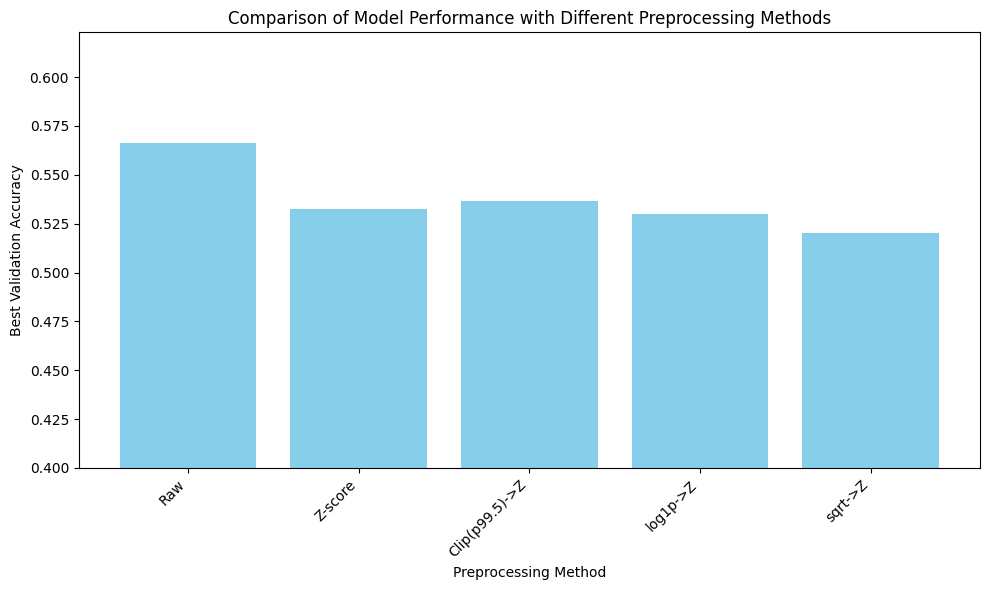

In [221]:
# Summarize results
results_df = pd.DataFrame(all_results)
print("\n--- Comparison of Preprocessing Methods ---")
print(results_df[['name', 'best_val_acc']].sort_values(by='best_val_acc', ascending=False))

# Visualize results
plt.figure(figsize=(10, 6))
plt.bar(results_df['name'], results_df['best_val_acc'], color='skyblue')
plt.xlabel("Preprocessing Method")
plt.ylabel("Best Validation Accuracy")
plt.title("Comparison of Model Performance with Different Preprocessing Methods")
plt.ylim(0.4, results_df['best_val_acc'].max() * 1.1) # Adjust y-axis for better visibility
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Will reuse many of the functions define in the MiniMLP Section.

# Experiment and Optimize

Will reuse many of the functions define in the MiniMLP Section.

## Models

In [222]:
class ExperiementMLP(nn.Module):
    def __init__(
        self,
        in_dim: int,
        n_classes: int,
        hidden=None,
        dropout: float = 0.10,
        activation: str = "relu",   # Options: relu, gelu, tanh
    ):
        super().__init__()
        layers = []
        prev = in_dim

        # accidently used the default a lot ;|
        assert hidden is not None, "ExperiementMLP: pass 'hidden' explicitly."

        act_name = activation.lower()

        # choose activation module once
        if act_name == "relu":
            act_layer = nn.ReLU
        elif act_name == "gelu":
            act_layer = nn.GELU
        elif act_name == "tanh":
            act_layer = nn.Tanh
        else:
            raise ValueError(f"Unsupported activation: {activation}")

        # Append Layers
        for h in hidden:
            layers.append(nn.Linear(prev, h))
            layers.append(act_layer())
            layers.append(nn.Dropout(dropout))
            prev = h

        layers.append(nn.Linear(prev, n_classes))
        self.net = nn.Sequential(*layers)

        # Weight iniatlization --> Kaiming for ReLU/GELU and Xavier for tanh
        for m in self.net:
            if isinstance(m, nn.Linear):
                if act_name in ("relu", "gelu"):
                    nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                elif act_name == "tanh":
                    nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

## Configuration Intialization for Sweep.

Best Parameters

In [223]:
def count_parameters(model: nn.Module) -> int:
    """Count the total number of trainable parameters in a  model to compere overal size"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

**Optimizer Hyperparater Configuration.**: step size + weight decay

In [224]:
# GLOBAL parameters
""""
    Options
    Raw": (X_train_raw, X_test_raw),
    "Z-score": (Xtr_A, Xte_A),
    "Clip(p99.5)->Z": (Xtr_B, Xte_B),
    "log1p->Z": (Xtr_C, Xte_C),
    "sqrt->Z": (Xtr_C2, Xte_C2),
"""
DATA_SET = "Raw"
BATCH_SIZE = 1024
PATIENCE = 7
EPOCHS = 200

# ------ Optimizer Hyperparameter Configuration: step size + weight decay -----

# Current best model is shown below

OPT_CONFIGS = {
    "adam_lr1e-4_wd1e-5": dict(
        opt_name="adam",
        lr=1e-4,
        weight_decay=1e-5,
    ),
}

# ------ Architecture Configuration: depth + width + activation + dropout -----

ARCH_CONFIGS = {
    "mlp_shallow_wide": dict(
        hidden=(4096, 2048),
        activation="gelu",
        dropout=0.10,
    ),
}


In [225]:
# Reload to ensure consistency and control over values.
train_loader, val_loader, in_dim = initialize_loaders(
        dataset_key=DATA_SET,
        batch_size=BATCH_SIZE,
    )

## Run Sweep

In [226]:
# ------------------------------------------------------------
# Full sweep: over architectures and optimizer configs
# ------------------------------------------------------------

OPT_RESULTS = {}

for arch_tag, arch_cfg in ARCH_CONFIGS.items():
    hidden     = arch_cfg["hidden"]
    activation = arch_cfg["activation"]
    dropout    = arch_cfg["dropout"]
    model_type = arch_cfg.get("model_type", "mlp")

    for opt_tag, cfg in OPT_CONFIGS.items():
        run_key = f"{arch_tag}__{opt_tag}"

        # Build title directly from the actual hyperparameters used
        exp_name = (
            f"MLP__{run_key}"
            f"__h{hidden}"
            f"__act{activation}"
            f"__step{cfg['lr']:.0e}" # step size (learning rate)
            f"__wd{cfg['weight_decay']:.0e}"  # weight decay
            f"__bs{BATCH_SIZE}"
            f"__ep{EPOCHS}"
        )

        print(f"\n=== Running config: {exp_name} ===")

        # for reproducibility per run
        set_seed(42)

        # -------------------------
        # Build model
        # -------------------------

        model = ExperiementMLP(
            in_dim=in_dim,
            n_classes=N_CLASSES,
            hidden=hidden,
            dropout=dropout,
            activation=activation,
        )


        n_params = count_parameters(model)
        depth    = len(hidden)
        print(f"Model params: {n_params:,} | depth: {depth}")

        # -------------------------
        # Train
        # -------------------------
        model, history, best_val = train_model(
            model,
            train_loader,
            val_loader,
            device=device,
            epochs=EPOCHS,
            lr=cfg["lr"],
            weight_decay=cfg["weight_decay"],
            patience=PATIENCE,
            grad_clip=None,
            opt_name=cfg["opt_name"],
            label_smoothing=0.10,
        )

        print(f"[{run_key}] best val_acc = {best_val:.4f}")

        # -------------------------
        # Meta info for logging / checkpoint
        # -------------------------
        meta = {
            "run_name": exp_name,
            "dataset": DATA_SET,
            "model_type": model_type,
            "hidden": list(hidden),
            "dropout": float(dropout),
            "activation": activation,
            "optimizer": cfg["opt_name"],
            "lr": float(cfg["lr"]),
            "weight_decay": float(cfg["weight_decay"]),
            "batch_size": int(BATCH_SIZE),
            "epochs_requested": int(EPOCHS),
            "patience": int(PATIENCE),
            "seed": 42,
            "opt_tag": opt_tag,
            "arch_tag": arch_tag,
            "n_params": int(n_params),
            "depth": int(depth),
            "best_val_acc": float(best_val),
        }
        # Save epoch by epoch data for plotting in other sessions
        meta["history"] = {
            "train_loss": history["train_loss"],
            "val_loss":   history["val_loss"],
            "train_acc":  history["train_acc"],
            "val_acc":    history["val_acc"],
        }

        # -------------------------
        # Register run: saves checkpoint + logs JSON/TXT + updates GLOBAL_BEST
        # -------------------------
        register_run(
            name=exp_name,
            model=model,
            val_acc=best_val,
            meta=meta,
        )

        # -------------------------
        # Store results for ranking printout
        # -------------------------
        OPT_RESULTS[run_key] = dict(
            best_val=best_val,
            history=history,
            opt_name=cfg["opt_name"],
            lr=cfg["lr"],
            weight_decay=cfg["weight_decay"],
            hidden=hidden,
            arch_tag=arch_tag,
            opt_tag=opt_tag,
            activation=activation,
            dropout=dropout,
        )

# ------------------------------------------------------------
# 4. Global ranking across all combinations
# ------------------------------------------------------------
print("\n=== Optimization config ranking (all depth/width × opt combos) ===")
for tag, info in sorted(
    OPT_RESULTS.items(),
    key=lambda kv: kv[1]["best_val"],
    reverse=True,
):
    h_str = "(" + ", ".join(str(h) for h in info["hidden"]) + ")"
    print(
        f"{tag:35s}  "
        f"{info['opt_name']:7s}  "
        f"h={h_str:24s}  "
        f"act={info['activation']:4s}  "
        f"do={info['dropout']:.2f}  "
        f"lr={info['lr']:.4g}  "
        f"wd={info['weight_decay']:.1e}  "
        f"best_val={info['best_val']:.4f}"
    )


=== Running config: MLP__mlp_shallow_wide__adam_lr1e-4_wd1e-5__h(4096, 2048)__actgelu__step1e-04__wd1e-05__bs1024__ep200 ===
Model params: 10,545,202 | depth: 2
epoch 01 | train_loss 3.7422 | val_loss 3.5272 | train_acc 0.1660 | val_acc 0.2011
epoch 02 | train_loss 3.3047 | val_loss 3.1320 | train_acc 0.2379 | val_acc 0.2646
epoch 03 | train_loss 3.0018 | val_loss 2.9414 | train_acc 0.2967 | val_acc 0.3097
epoch 04 | train_loss 2.8512 | val_loss 2.8468 | train_acc 0.3337 | val_acc 0.3306
epoch 05 | train_loss 2.7698 | val_loss 2.7994 | train_acc 0.3568 | val_acc 0.3439
epoch 06 | train_loss 2.7183 | val_loss 2.7648 | train_acc 0.3709 | val_acc 0.3541
epoch 07 | train_loss 2.6840 | val_loss 2.7431 | train_acc 0.3791 | val_acc 0.3610
epoch 08 | train_loss 2.6586 | val_loss 2.7308 | train_acc 0.3884 | val_acc 0.3639
epoch 09 | train_loss 2.6382 | val_loss 2.7188 | train_acc 0.3945 | val_acc 0.3675
epoch 10 | train_loss 2.6224 | val_loss 2.7125 | train_acc 0.3987 | val_acc 0.3704
epoch 11

# Evaluate

## Helpers

1. Training curves (loss and accuracy)
2. Prediction helper
3. Confusion matrix plot
4. Classification report
5. Example usage on validation set



In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import torch
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
)


### Rebuild model skeleton from saved meta

In [228]:

def _rebuild_model_from_meta(meta: dict) -> torch.nn.Module:
    """
    Rebuild an ExperiementMLP model that matches the training config
    recorded in `meta` (saved by register_run).

    Expected keys in meta:
      - model_type : usually "mlp"
      - hidden     : list of hidden sizes
      - activation : activation name, e.g. "gelu"
      - dropout    : float dropout rate

    For this dataset use:
      - in_dim    = 500 features
      - n_classes = 50 classes
    unless explicitly stored in meta.
    """
    model_type = meta.get("model_type", "mlp")
    hidden     = tuple(meta.get("hidden", []))
    activation = meta.get("activation", "gelu")
    dropout    = float(meta.get("dropout", 0.10))

    # Input / output dimensions: prefer meta, else defaults
    in_dim    = int(meta.get("in_dim", 500))
    n_classes = int(meta.get("n_classes", 50))

    # "mlp" means ExperiementMLP --> safeguard for other model runs
    if model_type == "mlp":
        return ExperiementMLP(
            in_dim=in_dim,
            n_classes=n_classes,
            hidden=hidden,
            dropout=dropout,
            activation=activation,
        )

    raise ValueError(f"Unknown model_type in meta: {model_type}")

Reload best pointer on restart

In [229]:
def _load_model_from_pointer(ptr: dict) -> torch.nn.Module:
    """
    Given a pointer dict with 'ckpt_path', rebuild the model using
    the saved 'extras' meta and load its state_dict.
    """
    ckpt_path = ptr["ckpt_path"]
    assert os.path.exists(ckpt_path), f"Checkpoint not found: {ckpt_path}"

    payload = torch.load(ckpt_path, map_location="cpu")
    state   = payload["state_dict"]
    meta    = payload.get("extras", {})

    model = _rebuild_model_from_meta(meta)
    model.load_state_dict(state)
    return model

# --- GLOBAL_BEST from drive if needed ---
if "GLOBAL_BEST" not in globals() or GLOBAL_BEST is None:
    ptr = load_global_best_pointer()
    if ptr is None:
        raise RuntimeError("No GLOBAL_BEST.json pointer found on drive.")
    GLOBAL_BEST = dict(ptr)
    GLOBAL_BEST["model"] = None

# --- If model is missing, load it now ---
if GLOBAL_BEST.get("model") is None:
    print("GLOBAL_BEST.model is None --> loading from checkpoint")
    best_model = _load_model_from_pointer(GLOBAL_BEST)
    GLOBAL_BEST["model"] = best_model
else:
    print(" GLOBAL_BEST already has a model in RAM")

print("[ GLOBAL_BEST pointer:")
print(json.dumps({k: v for k, v in GLOBAL_BEST.items() if k != "model"}, indent=2))

 GLOBAL_BEST already has a model in RAM
[ GLOBAL_BEST pointer:
{
  "name": "MLP__mlp_shallow_wide__adam_lr1e-4_wd1e-5__h(4096, 2048)__actgelu__step1e-04__wd1e-05__bs1024__ep200",
  "val_acc": 0.6918078239396959,
  "ckpt_path": "/content/drive/MyDrive/DATA_DIR/runs/checkpoints/MLP__mlp_shallow_wide__adam_lr1e-4_wd1e-5__h(4096, 2048)__actgelu__step1e-04__wd1e-05__bs1024__ep200__20251129-045804.pt",
  "meta_path": "/content/drive/MyDrive/DATA_DIR/runs/meta/MLP__mlp_shallow_wide__adam_lr1e-4_wd1e-5__h(4096, 2048)__actgelu__step1e-04__wd1e-05__bs1024__ep200__20251129-045804.json"
}


### Plot training curves

In [230]:
def plot_training_curves(history: dict, title: str = "") -> None:
    """Plot loss and accuracy curves from the training history dict."""
    epochs = range(1, len(history["train_loss"]) + 1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Loss
    axs[0].plot(epochs, history["train_loss"], label="train_loss")
    axs[0].plot(epochs, history["val_loss"],   label="val_loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].set_title("Loss vs Epochs")
    axs[0].legend()

    # Accuracy
    axs[1].plot(epochs, history["train_acc"], label="train_acc")
    axs[1].plot(epochs, history["val_acc"],   label="val_acc")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_title("Accuracy vs Epochs")
    axs[1].legend()

    if title:
        fig.suptitle(title)

    plt.tight_layout()
    plt.show()


### Select and load run for evaluation

 Rebuild model from saved meta used by eval + submission

In [231]:
def select_run_for_evaluation(which: str = "best"):
    """
    Choose which run to evaluate.

    which = "best":
        Use select_model_for_submission() to recover the best model
        (GLOBAL_BEST in RAM or from checkpoint).
        Try to fetch history from OPT_RESULTS[run_key]["history"] if present.

    which = "last":
        Use the last in-memory `model` and `history` created by the sweep.
    """
    which = which.lower()

    # --------------------------------------------
    # Option 1: use best model (GLOBAL_BEST / disk)
    # --------------------------------------------
    if which == "best":
        mdl, name, valacc = select_model_for_submission()
        history = None

        # Infer arch_tag / opt_tag from run name pattern "MLP__arch_tag__opt_tag__..."
        base = name
        if base.startswith("MLP__"):
            base = base[len("MLP__"):]
        parts    = base.split("__")
        arch_tag = parts[0] if len(parts) > 0 else "unknown_arch"
        opt_tag  = parts[1] if len(parts) > 1 else "unknown_opt"

        # If OPT_RESULTS exists and has this run, pull history from there
        run_key = f"{arch_tag}__{opt_tag}"
        if "OPT_RESULTS" in globals() and run_key in OPT_RESULTS:
            history = OPT_RESULTS[run_key]["history"]

        print(f"[eval] Selected BEST run → {arch_tag}__{opt_tag} | val_acc={valacc:.4f}")
        return mdl, history, arch_tag, opt_tag

    # --------------------------------------------
    # Option 2: last in-memory run
    # --------------------------------------------
    elif which == "last":
        if "model" not in globals():
            raise RuntimeError("No 'model' found in globals() for which='last'.")

        eval_model   = model
        eval_history = globals().get("history", None)

        arch_tag = globals().get("arch_tag", "unknown_arch")
        opt_tag  = globals().get("opt_tag", "unknown_opt")

        print(f"[eval] Selected LAST run → {arch_tag}__{opt_tag}")
        return eval_model, eval_history, arch_tag, opt_tag

    else:
        raise ValueError("which must be 'best' or 'last'")

In [232]:
def evaluate_split(
    model: torch.nn.Module,
    loader,
    device: torch.device,
    split_name: str = "val",
):
    """
    Compute loss, accuracy, macro precision/recall/F1 and per-class recall on a data split.

    Returns a dict with:
      - loss
      - accuracy
      - precision_macro
      - recall_macro
      - f1_macro
      - confusion_matrix
      - per_class_recall
      - y_true, y_pred
    """
    criterion = torch.nn.CrossEntropyLoss()

    model.eval()
    all_preds   = []
    all_labels  = []
    total_loss  = 0.0
    total_count = 0

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            logits = model(xb)
            loss   = criterion(logits, yb)

            bs = yb.size(0)
            total_loss  += loss.item() * bs
            total_count += bs

            preds = logits.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(yb.cpu())

    all_preds  = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    avg_loss = total_loss / total_count
    acc      = accuracy_score(all_labels, all_preds)
    prec_mac, rec_mac, f1_mac, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="macro", zero_division=0
    )
    cm = confusion_matrix(all_labels, all_preds)
    per_class_recall = cm.diagonal() / np.maximum(cm.sum(axis=1), 1)

    print(
        f"[{split_name}] loss={avg_loss:.4f} | "
        f"acc={acc:.4f} | prec_macro={prec_mac:.4f} | "
        f"recall_macro={rec_mac:.4f} | f1_macro={f1_mac:.4f}"
    )

    return dict(
        loss=avg_loss,
        accuracy=acc,
        precision_macro=prec_mac,
        recall_macro=rec_mac,
        f1_macro=f1_mac,
        confusion_matrix=cm,
        per_class_recall=per_class_recall,
        y_true=all_labels,
        y_pred=all_preds,
    )


In [233]:
def summarize_splits(results_by_split: dict) -> pd.DataFrame:
    """
    Build a small metrics table (rows = split, cols = core metrics).
    results_by_split: {"train": res_dict, "val": res_dict, ...}
    """
    rows = []
    for split_name, res in results_by_split.items():
        rows.append(
            dict(
                split=split_name,
                loss=res["loss"],
                accuracy=res["accuracy"],
                precision_macro=res["precision_macro"],
                recall_macro=res["recall_macro"],
                f1_macro=res["f1_macro"],
            )
        )
    df = pd.DataFrame(rows).set_index("split")
    return df

### Confusion Matrix

In [234]:
def top_confused_pairs(cm: np.ndarray, k: int = 5):
    """
    Return top-k (true, pred, confusion_rate) pairs sorted by conditional error.
    confusion_rate = cm[true, pred] / sum(cm[true,:])
    """
    cm = cm.astype(float)
    confusions = []
    C = cm.shape[0]
    for t in range(C):
        row_sum = cm[t].sum()
        if row_sum == 0:
            continue
        for p in range(C):
            if t == p:
                continue
            rate = cm[t, p] / row_sum
            confusions.append((rate, t, p))
    confusions.sort(reverse=True, key=lambda x: x[0])
    return confusions[:k]

In [235]:
def plot_confusion_matrix(
    y_true,
    y_pred,
    class_names=None,
    normalize: bool = True,
    title: str = "Confusion Matrix",
) -> None:
    """
    Plot a confusion matrix heatmap.

    - For many classes (e.g., 50), we show fewer axis ticks and
      skip writing the numeric value in every cell.
    """
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype("float") / np.maximum(cm.sum(axis=1, keepdims=True), 1)

    n_classes = cm.shape[0]

    if class_names is None:
        class_names = [str(i) for i in range(n_classes)]

    # Bigger figure so the diagonal is easier to see
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation="nearest", aspect="auto")
    ax.set_title(title)
    fig.colorbar(im, ax=ax)

    # ---  show fewer ticks if many classes ---
    if n_classes > 20:
        # for 50 classes, show every 5th
        step = max(1, n_classes // 10)   # about 10 ticks
        tick_idx = np.arange(0, n_classes, step)
    else:
        tick_idx = np.arange(n_classes)

    ax.set_xticks(tick_idx)
    ax.set_yticks(tick_idx)
    ax.set_xticklabels([class_names[i] for i in tick_idx], rotation=45, ha="right")
    ax.set_yticklabels([class_names[i] for i in tick_idx])

    # --- only for small matrices ---
    if n_classes <= 15:
        fmt = ".2f" if normalize else "d"
        thresh = cm.max() / 2.0
        for i in range(n_classes):
            for j in range(n_classes):
                ax.text(
                    j,
                    i,
                    format(cm[i, j], fmt),
                    ha="center",
                    va="center",
                    color="white" if cm[i, j] > thresh else "black",
                )

    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

In [236]:
def print_classification_report(y_true, y_pred, class_names=None) -> None:
    """Print precision / recall / F1 per class."""
    print(
        classification_report(
            y_true,
            y_pred,
            target_names=class_names if class_names is not None else None,
            digits=4,
        )
    )

## Plot

[eval] Selected LAST run → mlp_shallow_wide__adam_lr1e-4_wd1e-5


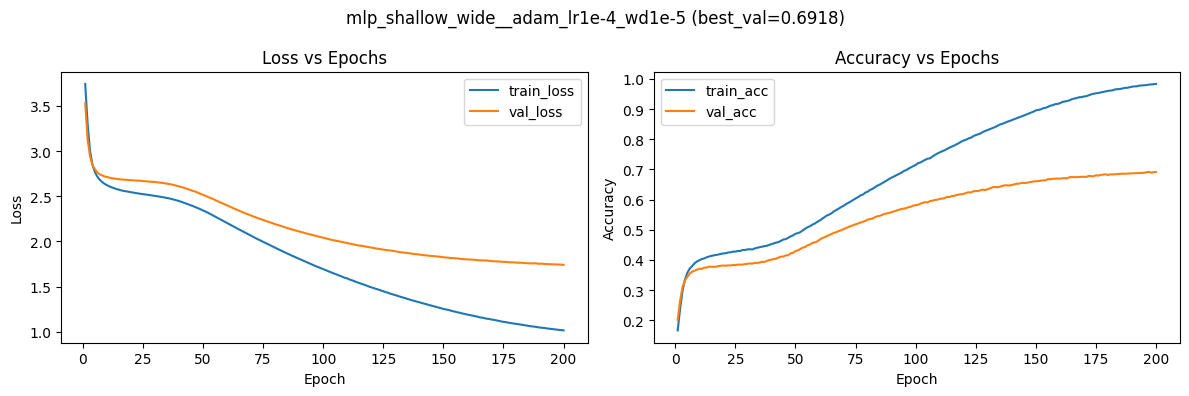

[train] loss=0.2901 | acc=0.9964 | prec_macro=0.9964 | recall_macro=0.9964 | f1_macro=0.9964
[val] loss=1.2189 | acc=0.6918 | prec_macro=0.6941 | recall_macro=0.6918 | f1_macro=0.6923

=== Summary metrics table (train vs val vs test) ===


,loss,accuracy,precision_macro,recall_macro,f1_macro
split,,,,,
train,0.290063,0.996426,0.996428,0.996426,0.996425
val,1.218896,0.691808,0.694136,0.691810,0.692345


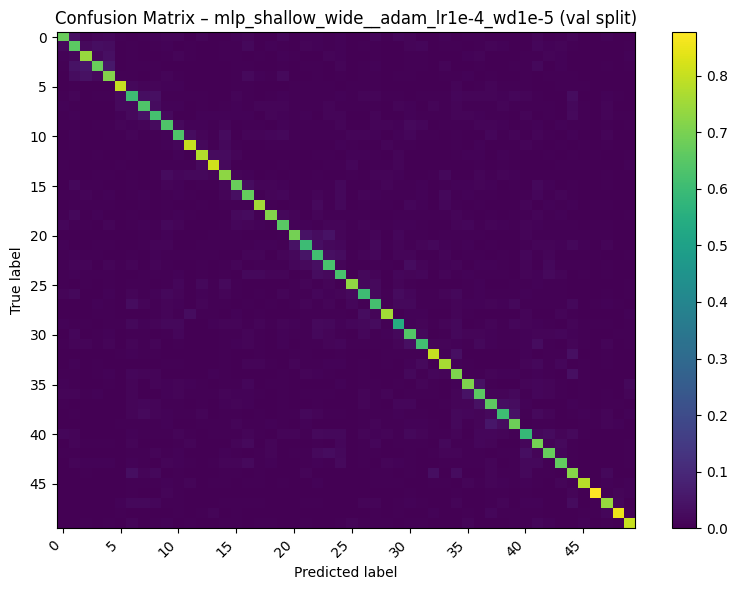


=== Top 5 most confused class pairs (val split) ===


,true_class,pred_class,error_rate
0,3,4,0.056277
1,39,37,0.052061
2,3,2,0.051948
3,22,21,0.049784
4,8,7,0.043384



=== Per-class recall (val split) ===


,recall
class,
29,0.541126
40,0.586580
21,0.600868
6,0.603896
38,0.603896
26,0.603896
22,0.610390
31,0.612554
8,0.618221



=== Classification report (val split) ===
              precision    recall  f1-score   support

           0     0.7446    0.6753    0.7083       462
           1     0.6163    0.6551    0.6351       461
           2     0.7511    0.7397    0.7454       461
           3     0.7536    0.6753    0.7123       462
           4     0.6962    0.7143    0.7051       462
           5     0.8390    0.8009    0.8195       462
           6     0.5788    0.6039    0.5911       462
           7     0.6621    0.6334    0.6475       461
           8     0.6223    0.6182    0.6202       461
           9     0.6074    0.6364    0.6216       462
          10     0.6389    0.6334    0.6362       461
          11     0.7923    0.8026    0.7974       461
          12     0.7495    0.7771    0.7630       462
          13     0.8210    0.8139    0.8174       462
          14     0.6634    0.7267    0.6936       461
          15     0.6460    0.6768    0.6610       461
          16     0.6390    0.6681    0

In [237]:
EVAL_TARGET = "last"   # change to "last" if you want last-trained model

eval_model, eval_history, eval_arch_tag, eval_opt_tag = select_run_for_evaluation(EVAL_TARGET)
eval_model = eval_model.to(device).eval()

# Curves for underfitting/overfitting tequnical analysis
plot_training_curves(
    eval_history,
    title=(
        f"{eval_arch_tag}__{eval_opt_tag} "
        f"(best_val={eval_history.get('best_val_acc', float('nan')):.4f})"
        if "best_val_acc" in eval_history
        else f"{eval_arch_tag}__{eval_opt_tag}"
    ),
)

# Metrics for train / val
results_by_split = {}

results_by_split["train"] = evaluate_split(eval_model, train_loader, device, split_name="train")
results_by_split["val"]   = evaluate_split(eval_model, val_loader,   device, split_name="val")

metrics_table = summarize_splits(results_by_split)
print("\n=== Summary metrics table (train vs val vs test) ===")
display(metrics_table)

# Per-class stuff using val split for the tec report
val_res   = results_by_split["val"]
y_val     = val_res["y_true"]
y_val_pred= val_res["y_pred"]
cm_val    = val_res["confusion_matrix"]

# Confusion matrix heatmap
CLASS_NAMES = [str(i) for i in range(int(globals().get("N_CLASSES", cm_val.shape[0])))]
plot_confusion_matrix(
    y_val,
    y_val_pred,
    class_names=CLASS_NAMES,
    normalize=True,
    title=f"Confusion Matrix – {eval_arch_tag}__{eval_opt_tag} (val split)",
)

# Top confused pairs using table-style for clarity
top5 = top_confused_pairs(cm_val, k=5)
top_confused_df = pd.DataFrame(
    [
        {"true_class": t, "pred_class": p, "error_rate": rate}
        for (rate, t, p) in top5
    ]
)
print("\n=== Top 5 most confused class pairs (val split) ===")
display(top_confused_df)

# Per-class recall table (val)
per_class_recall = val_res["per_class_recall"]
per_class_df = pd.DataFrame(
    {
        "class": np.arange(len(per_class_recall)),
        "recall": per_class_recall,
    }
).set_index("class")

print("\n=== Per-class recall (val split) ===")
display(per_class_df.sort_values("recall"))

# Full classification report (val) for precision/recall/F1 by class
print("\n=== Classification report (val split) ===")
print_classification_report(y_val, y_val_pred, class_names=CLASS_NAMES)

# Submission logic

### Select model for submission

In [151]:
def select_model_for_submission(
    last_model=None,
    last_name: str = None,
    last_valacc: float = None,
):
    """
    Choose which model to use for submission.

    Priority:
      1) In-memory GLOBAL_BEST (set by register_run during this session).
      2) Pointer JSON + checkpoint on disk (GLOBAL_BEST pointer).
      3) Explicit last_model argument (if provided).
      4) Fallback: last trained `model` from this notebook (globals()).
    """

    # --- Case 1: GLOBAL_BEST from this session ---
    if "GLOBAL_BEST" in globals() and isinstance(GLOBAL_BEST, dict) and ("model" in GLOBAL_BEST):
        mdl    = GLOBAL_BEST["model"]
        name   = str(GLOBAL_BEST.get("name", "best"))
        valacc = float(GLOBAL_BEST.get("val_acc", -1.0))
        print(f"[submit] Using GLOBAL_BEST from RAM -> {name} | val_acc={valacc:.4f}")
        return mdl, name, valacc

    # --- Case 2: pointer on disk (BEST_JSON) ---
    if "load_global_best_pointer" in globals():
        ptr = load_global_best_pointer()
        if ptr is not None:
            ckpt_path = ptr.get("ckpt_path", "")
            if os.path.exists(ckpt_path):
                payload = torch.load(ckpt_path, map_location="cpu")
                meta    = payload.get("extras", {})
                mdl     = _rebuild_model_from_meta(meta)
                mdl.load_state_dict(payload["state_dict"])
                name   = ptr.get("name", "best_from_disk")
                valacc = float(ptr.get("val_acc", -1.0))
                print(f"[submit] Recovered GLOBAL_BEST from disk → {name} | val_acc={valacc:.4f}")
                return mdl, name, valacc
            else:
                print("[submit] Pointer found, but checkpoint path does not exist on disk.")

    # --- Case 3: explicit last_model argument ---
    if last_model is not None:
        mdl    = last_model
        name   = last_name or "last_from_arg"
        valacc = float(last_valacc) if last_valacc is not None else -1.0
        print(f"[submit] Using explicit last_model -> {name} | val_acc={valacc:.4f}")
        return mdl, name, valacc

    # --- Case 4: fallback to last trained model in globals() ---
    if "model" not in globals():
        raise RuntimeError("No GLOBAL_BEST, no pointer, no explicit last_model, and no `model` in globals() for submission.")

    mdl    = model
    name   = globals().get("RUN_NAME", "current")
    valacc = float(globals().get("best_val_acc", -1.0))
    print(f"[submit] Fallback to most recent trained model (globals) -> {name} | val_acc={valacc:.4f}")
    return mdl, name, valacc

[submit] Using GLOBAL_BEST from RAM -> MLP__mlp_shallow_wide__adam_lr1e-4_wd1e-4 | val_acc=0.7805


### Make sure preprocessing matches train stats

In [152]:
# Make sure basic globals exist
assert "TEST_PATH"  in globals(), "Define TEST_PATH earlier (path to test.csv)."
assert "DATA_DIR"   in globals(), "Define DATA_DIR earlier."
assert "SAMPLE_SUB" in globals(), "Define SAMPLE_SUB earlier (sample_submission.csv path)."
assert "preprocessed_datasets" in globals(), "Build preprocessed_datasets before submission."

# Rebuild X_test_proc to MATCH the training preprocessing
if DATA_SET not in preprocessed_datasets:
    raise KeyError(f"dataset_key '{DATA_SET}' not found in preprocessed_datasets.")

_, X_test_proc = preprocessed_datasets[DATA_SET]

print(f"[submit] Using dataset_key= '{DATA_SET}' for test preprocessing.")
print("X_test_proc shape:", X_test_proc.shape)

[submit] Reusing existing X_test_proc from memory.
X_test_proc shape: (49460, 500)


### Batche inference of logits

In [153]:
def predict_logits_in_batches(model, X, device, batch_size=1024):
    """
    Run model on all rows of X (NumPy array) in batches and
    return logits as a NumPy array of shape [N, num_classes].
    """
    model.eval()
    all_logits = []
    n = X.shape[0]

    with torch.no_grad():
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            xb  = torch.from_numpy(X[start:end]).float().to(device)
            logits = model(xb)          # [B, num_classes]
            all_logits.append(logits.cpu().numpy())

    return np.concatenate(all_logits, axis=0)

submit_model, best_name, best_valacc = select_model_for_submission()
submit_model = submit_model.to(device).eval()

print(f"Using model: {best_name} | val_acc={best_valacc:.4f}")

logits_test = predict_logits_in_batches(
    model=submit_model,
    X=X_test_proc,
    device=device,
    batch_size=BATCH_SIZE,
)
print("logits_test shape:", logits_test.shape)


[submit] Using GLOBAL_BEST from RAM -> MLP__mlp_shallow_wide__adam_lr1e-4_wd1e-4 | val_acc=0.7805
Using model: MLP__mlp_shallow_wide__adam_lr1e-4_wd1e-4 | val_acc=0.7805
logits_test shape: (49460, 50)


### Create submission CSV

In [154]:
def create_submission(test_csv_path, predictions, out_csv_path,
                      from_logits=True, n_classes=None, sample_csv_path=None):
    """
    Build a Kaggle submission CSV with columns: id, label.

    Arguments:
      test_csv_path  : path to test.csv (for id column)
      predictions    : either logits [N, K] or label ids [N]
      out_csv_path   : where to write the CSV
      from_logits    : if True, argmax over axis=1 to get labels
      n_classes      :  check on logits shape
      sample_csv_path: path to sample_submission.csv to sanity-check columns
    """
    test_df = pd.read_csv(test_csv_path)
    ids     = test_df["id"].to_numpy()

    # Turn logits into labels if needed
    if from_logits:
        if predictions.ndim != 2:
            raise ValueError("from_logits=True but predictions is not 2D (N, K).")
        if n_classes is not None and predictions.shape[1] != n_classes:
            raise ValueError(
                f"Expected logits with {n_classes} classes, got shape {predictions.shape}"
            )
        labels = predictions.argmax(axis=1)
    else:
        labels = predictions
        if labels.ndim != 1:
            raise ValueError("from_logits=False but predictions is not a 1D label array.")

    if ids.shape[0] != labels.shape[0]:
        raise ValueError(f"id count ({ids.shape[0]}) != label count ({labels.shape[0]})")

    df_sub = pd.DataFrame({"id": ids, "label": labels.astype(int)})

    # compare column names with sample_submission
    if sample_csv_path is not None and os.path.exists(sample_csv_path):
        sample = pd.read_csv(sample_csv_path)
        if list(sample.columns) != ["id", "label"]:
            print("[submit] WARNING: sample_submission columns are not ['id', 'label'].")
        else:
            print("[submit] Sample submission format OK.")

    df_sub.to_csv(out_csv_path, index=False)
    print(f"[submit] Wrote submission to {out_csv_path}")
    return df_sub


In [155]:
sub_dir = os.path.join(DATA_DIR, "submissions")
os.makedirs(sub_dir, exist_ok=True)

ts = time.strftime("%Y%m%d-%H%M%S")
safe_run = (best_name or "run").replace(" ", "_").replace("/", "_")

if isinstance(best_valacc, (int, float)) and best_valacc >= 0:
    acc_tag = f"{best_valacc:.4f}"
else:
    acc_tag = "NA"

OUT_SUB = os.path.join(sub_dir, f"{safe_run}__val{acc_tag}__{ts}.csv")

df_sub = create_submission(
    test_csv_path=TEST_PATH,
    predictions=logits_test,
    out_csv_path=OUT_SUB,
    from_logits=True,
    n_classes=N_CLASSES,# defined earlier as 50
    sample_csv_path=SAMPLE_SUB,
)

print(f"Submission saved to: {OUT_SUB}")
display(df_sub.head())

[submit] Sample submission format OK.
[submit] Wrote submission to /content/drive/MyDrive/DATA_DIR/submissions/MLP__mlp_shallow_wide__adam_lr1e-4_wd1e-4__val0.7805__20251129-035427.csv
Submission saved to: /content/drive/MyDrive/DATA_DIR/submissions/MLP__mlp_shallow_wide__adam_lr1e-4_wd1e-4__val0.7805__20251129-035427.csv


,id,label
0,0,23
1,1,22
2,2,22
3,3,22
4,4,22
